In [1]:
import torch
from torch import nn
from torchvision import transforms, models
import matplotlib.pyplot as plt

In [218]:
inception_model = models.vgg16(pretrained=True)

In [279]:
[i for i,_ in inception_model.named_children()]

['features', 'avgpool', 'classifier']

In [220]:
nn.Module.__getitem__ = lambda s,i: list(s.children())[i]

In [221]:
class CutModel():
    def __init__(self, model, layer, channel):
        super().__init__()
        self.model,self.layer,self.channel=model,layer,channel
        for p in self.model.parameters():
            p.requires_grad_(False)
        self.add_hook()
        
    def add_hook(self):
        def activation_fn(module,input,output):
            self.loss = -torch.mean(output[:,self.channel])
        self.model[self.layer].register_forward_hook(activation_fn)
        
    def __call__(self, x):
        for i,m in enumerate(self.model.children()):
            x = m(x)
            if i == self.layer:
                break
        return x

In [428]:
model = CutModel(inception_model.features, 21, 17)

In [429]:
def random_im():
    im = torch.rand((3,224,224))*30 + 160
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    im /= 255
    im -= mean[..., None, None]
    im /= std[..., None, None]
    im.unsqueeze_(0)
    im.requires_grad_(True)
    return im

In [430]:
im = random_im()
im.requires_grad

True

In [431]:
def norm(im):
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    im /= 255
    im -= mean[..., None, None]
    im /= std[..., None, None]
    im.unsqueeze_(0)
    im.requires_grad_(True)
    return im

In [432]:
from PIL import Image

def denorm(im):
    im = im.detach().clone().cpu().squeeze()
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    
    im *= std[..., None, None]
    im += mean[..., None, None]
    im *= 254
    im += 0.5
    im = im.permute(1,2,0).numpy()
    im[im>255]=255
    im[im<0]=0
    
    im = Image.fromarray(im.round().astype('uint8'))
    return im

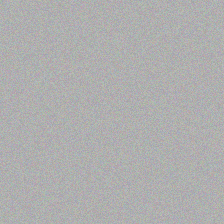

In [433]:
denorm(im)

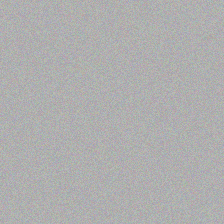

In [434]:
ITERS = 60

input_img = random_im()
optim = torch.optim.Adam([input_img], lr=0.1, weight_decay=1e-6)
denorm(input_img)

In [435]:
optim = torch.optim.Adam([input_img], lr=0.1, weight_decay=1e-6)

In [436]:
%%time

for i in range(ITERS):
    model(input_img)
    model.loss.backward()
    
    if i % 10 == 0:
        print(i, model.loss.item())
    
    optim.step()
    optim.zero_grad()
    
#     if i% 5 == 0:
#         with torch.no_grad():
#             input_img = Blur(3)(input_img)
#         input_img.requires_grad_(True)
#     input_img.data.add_(-0.1, input_img.grad.data)
#     model.zero_grad()

0 1.1967333555221558
10 -46.190189361572266
20 -87.09789276123047
30 -126.79163360595703
40 -167.99229431152344
50 -211.55084228515625
CPU times: user 2min, sys: 34.3 s, total: 2min 34s
Wall time: 22.4 s


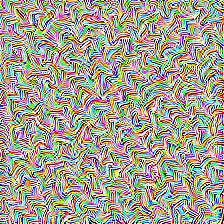

In [437]:
denorm(input_img)

In [287]:
from src import transforms
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [289]:
tfms = transforms.get_transforms(224, mean, std)

In [318]:
a = Image.open('dog.jpg')
x = tfms(a)
y=inception_model(x)
print(y.argmax(0))


RuntimeError: Expected 4-dimensional input for 4-dimensional weight 64 3 3, but got 3-dimensional input of size [3, 224, 224] instead

In [291]:
import torchvision

In [ ]:
a = Image.open('dog.jpg')

tfm = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    Blur(3),
    torchvision.transforms.ToPILImage()
])

In [317]:
%%timeit
tfm(a)

6.81 ms ± 33.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [320]:
class Blur():
    def __init__(self, kernel_size, variance=1., mean=1.):
        channels=3
        self.filter = nn.Conv2d(channels,channels,kernel_size, bias=False, groups=channels)
        kernel = torch.ones((channels,1,kernel_size,kernel_size))/(kernel_size*kernel_size)

        self.filter.weight.data = kernel
        self.filter.weight.requires_grad_(False)

    def __call__(self, x):
        if x.dim() == 3:
            x.unsqueeze_(0)
        return self.filter(x)

In [280]:
inception_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d